# Spyglass access tutorial
This notebook showcase the example sessions from Kind Lab datesets

---

## Import Required Libraries

In [1]:
from pathlib import Path
import datajoint as dj
dj.conn(use_tls=False)  # configurable in config using [datababse.use_tls]
dj_local_conf_path = "/home/alessandra/CatalystNeuro/kind-lab-to-nwb/dj_local_conf.json"
dj.config.load(dj_local_conf_path)  # load config for database connection info
# to prevent needing to load before import, consider saving the config
dj.config.save_global()  # default loaded for anywhere on the system
dj.config.save_local()  # loaded when running a script from this directory

# spyglass.common has the most frequently used tables
import spyglass.common as sgc  # this import connects to the database
# spyglass.data_import has tools for inserting NWB files into the database
import spyglass.data_import as sgi
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename, get_nwb_file

from kind_lab_to_nwb.spyglass_utils import AnnotatedEvents

# Visualization
import matplotlib.pyplot as plt
# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

[2025-12-18 11:04:50,600][INFO]: DataJoint 0.14.6 connected to root@localhost:3306
[2025-12-18 11:04:50,605][INFO]: DataJoint is configured from /home/alessandra/CatalystNeuro/kind-lab-to-nwb/dj_local_conf.json


## Spyglass database

In [2]:
sgc.Session()

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
sub-1072-Grin2b(6)_ses-OR-HabD1_.nwb,1072-Grin2b(6),University of Edinburgh,Kind,OR_HabD1-2023-09-11,Experimental Day 1. Individual rat placed in arena for 10 min habituation,2023-09-11 13:58:59,2023-09-11 13:58:59,"This experiment is part of the Rat Behavioural Phenotyping Pipeline Methodologies https://sidb.org.uk/facilities/rat-behavioural-phenotyping-pipeline/. As an initial effort to characterize the rat lines, these models are being behaviorally phenotyped at SIDB. Rat models are phenotyped according to a rigorous pipeline that assesses behaviours relevant to autism with intellectual disability, such as social and motor skills, and learning and sensory processing. Different cohorts of rats are run through different subsets of tasks to overcome potential order effects on behaviours and to limit the number of tasks each animal is put through. This experiment investigated object recognition memory in different rat models (Arid1b: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=14394518, Grin2b: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=14394515, Scn2a: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=25394530). The experimenter was blind to genotype throughout the experiment and watched the trials on a screen from outside the testing room. The task utilized a custom-built arena (60x60 cm) with black laminated wood walls and grey lino floor. Rats underwent habituation (3 days, 10 min each) followed by sample and test trials to assess their ability to recognize novel objects. The protocol included sample trials (15 min with two identical objects) and test trials (3 min) with one novel object. Both short-term (5 min delay) and long-term (24 hr delay) memory were assessed. Object exploration was recorded via CCTV camera and manually scored using BORIS software."
sub-1073-Grin2b(6)_ses-OLM-HabD2_.nwb,1073-Grin2b(6),University of Edinburgh,Kind,OLM_HabD2-2023-08-22,Experimental Day 2. Individual rat placed in arena for 10 min habituation,2023-08-22 14:22:37,2023-08-22 14:22:37,"This experiment is part of the Rat Behavioural Phenotyping Pipeline Methodologies https://sidb.org.uk/facilities/rat-behavioural-phenotyping-pipeline/. As an initial effort to characterize the rat lines, these models are being behaviorally phenotyped at SIDB. Rat models are phenotyped according to a rigorous pipeline that assesses behaviours relevant to autism with intellectual disability, such as social and motor skills, and learning and sensory processing. Different cohorts of rats are run through different subsets of tasks to overcome potential order effects on behaviours and to limit the number of tasks each animal is put through. This experiment investigated object location memory in different rat models (Arid1b: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=14394518, Grin2b: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=14394515, Scn2a: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=25394530). The experimenter was blind to genotype throughout the experiment and watched the trials on a screen from outside the testing room. The task utilized two custom-built arenas (60x60 cm) with different wall colors and bedding. Rats underwent habituation followed by sample and test trials to assess their ability to detect object location changes. The protocol included group habituation (10 min), individual habituation (2 days, 10 min each), sample trials (15 min with two identical objects), and test trials (3 min) with one object moved to a new location. Both short-term (5 min delay) and long-term (1 hr delay) memory were assessed. Object exploration was recorded via CCTV camera and manually scored using BORIS software."
sub-1275-Grin2b(10)_ses-AFC-2-HabD2_.nwb,1275_Grin2b(10),University of Edinburgh,Kind,AFC_2_HabD2,"Experimental Day 2. Habituation to

In [3]:
# Load session data
session_id = "MI-Test"
subject_id = "408-Arid1b(3)"
nwb_file_name = get_nwb_copy_filename(f"sub-{subject_id}_ses-{session_id}.nwb")
sgc.Session & {'nwb_file_name': nwb_file_name}


nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
sub-408-Arid1b(3)_ses-MI-Test_.nwb,408-Arid1b(3),University of Edinburgh,Kind,MI_Test,Experimental Day 3. Marble interaction test. Rat placed in arena with woodchip bedding and 20 marbles arranged in 4x5 grid for 20 min test period.,2022-11-23 00:00:00,2022-11-23 00:00:00,"This experiment is part of the Rat Behavioural Phenotyping Pipeline Methodologies https://sidb.org.uk/facilities/rat-behavioural-phenotyping-pipeline/. As an initial effort to characterize the rat lines, these models are being behaviorally phenotyped at SIDB. Rat models are phenotyped according to a rigorous pipeline that assesses behaviours relevant to autism with intellectual disability, such as social and motor skills, and learning and sensory processing. Different cohorts of rats are run through different subsets of tasks to overcome potential order effects on behaviours and to limit the number of tasks each animal is put through. This experiment investigated marble interaction behavior in different rat models (Arid1b: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=14394518, Grin2b: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=14394515, Scn2a: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=25394530) using a plastic box arena (63 x 50 x 30 cm) with wood chip bedding. The experimenter was blind to genotype and monitored trials from outside the testing room via video feed. The protocol involved three experimental days: two days of arena habituation (20 min each) followed by a test day with 20 black glass marbles arranged in a 4x5 grid. Between rats, the arena was cleared of debris and the wood chip bedding was mixed and flattened out. Behavioral data included manual scoring of marble manipulation time using BORIS software and movement tracking using ANY-Maze software. The experimental setup included two side-by-side arenas separated by a wooden panel, with CCTV camera recording and controlled lighting conditions (~20 lx)."


In [ ]:
sgc.Subject() & {'subject_id': subject_id}

=== SUBJECTS INFORMATION ===


subject_id,age,description,genotype,sex,species
408-Arid1b(3),None,Subject housed in standard housing conditions. Cage identifier: 1.0.,WT,M,Rattus norvegicus


In [16]:
start_time, stop_time = (sgc.IntervalList() & {'nwb_file_name': nwb_file_name , 'interval_list_name': '01'}).fetch1("valid_times")[0]
print(f"Start time: {start_time}, Stop time: {stop_time}")

Start time: 0.0, Stop time: 1280.9833333333333


In [20]:
sgc.CameraDevice()

camera_name,meters_per_pixel height / width of pixel in meters,manufacturer,model,lens,camera_id
BehavioralCamera,0.0004,,C920,Carl Zeiss lens with 20-step autofocus,0


---

# Access Annotated Behavioral Events <a id="events"></a>

The `nwbfile.processing["events]` contains annotated events. These are stored in the `AnnotatedEventsTable` type. The `AnnotatedEventsTable` type is a subtype of `DynamicTable`, where each row corresponds to a different event type. The table has a ragged (variable-length) 1D column of event times, such that each event type (row) is associated with an array of event times

You can convert the table to a `pandas.DataFrame` for easier exploration:


In [23]:
events = AnnotatedEvents()
# Fetch actions DataFrame
behavioral_events = events.fetch1_dataframe("annotated_events")
display(behavioral_events.head())

,duration,event_times,label,event_description
id,,,,
0,"[3.0, 0.9009999999999962, 12.600999999999999, ...","[70.901, 88.001, 96.101, 110.701, 129.503, 142...",paw on marble,"paw touching / gripping marble, not just walki..."
1,"[nan, nan]","[61.702, 1261.702]",start/stop,start and end of exp (20 min)


/tmp/ipykernel_95625/853228197.py:22: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((time, idx-0.4), duration, 0.8,


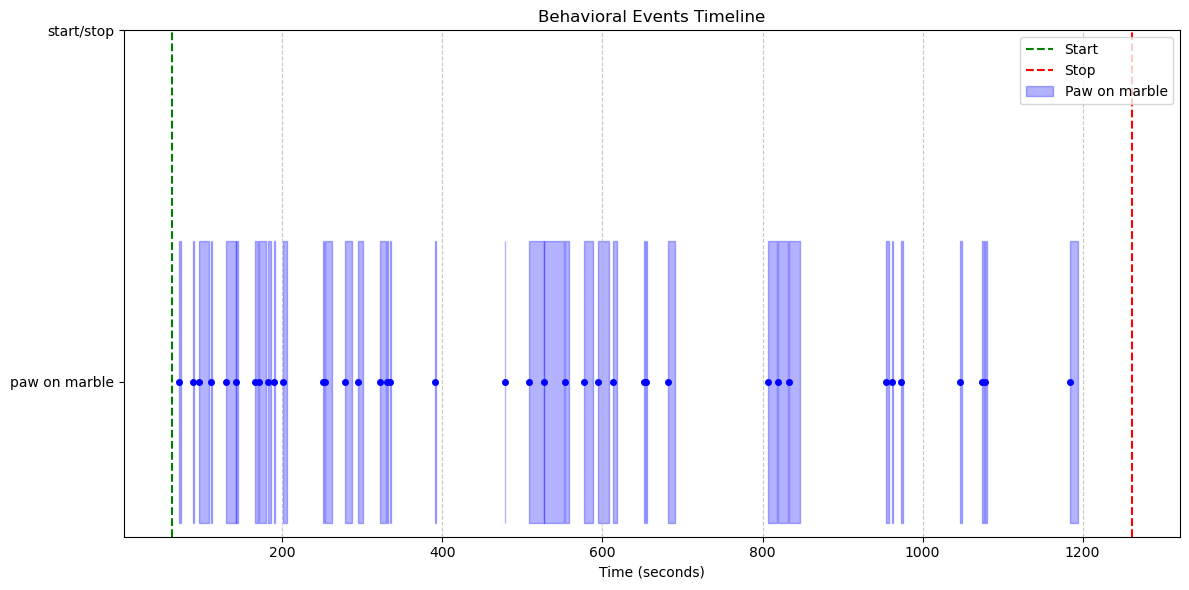

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, ax = plt.subplots(figsize=(12, 6))

# Extract event types and their times
for idx, row in behavioral_events.iterrows():
    label = row['label']
    times = np.array(row['event_times'])
    durations = np.array(row['duration'])
    
    # For start/stop events, plot vertical lines as before
    if label == 'start/stop':
        ax.axvline(x=times[0], color='green', linestyle='--', label='Start')
        ax.axvline(x=times[1], color='red', linestyle='--', label='Stop')
    else:
        # For paw on marble events, plot faded rectangles
        for i, (time, duration) in enumerate(zip(times, durations)):
            if not np.isnan(duration):
                # Add a faded rectangle for the duration of the event
                rect = plt.Rectangle((time, idx-0.4), duration, 0.8, 
                                    alpha=0.3, color='blue', 
                                    edgecolor='blue', linewidth=1)
                ax.add_patch(rect)
                
                # Add a dot at the start of each event
                ax.plot(time, idx, 'bo', markersize=4)

# Add labels and title
ax.set_xlabel('Time (seconds)')
ax.set_yticks(range(len(behavioral_events)))
ax.set_yticklabels(behavioral_events['label'])
ax.set_title('Behavioral Events Timeline')
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper right')

# Add a blue patch to the legend for the paw on marble events
from matplotlib.patches import Patch
blue_patch = Patch(color='blue', alpha=0.3, label='Paw on marble')
ax.legend(handles=[*by_label.values(), blue_patch], labels=[*by_label.keys(), 'Paw on marble'], loc='upper right')

plt.tight_layout()
plt.show()